/tmp/ipykernel_142766/3247149898.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


EWC CSV not found: /work/csv/uci-har/cil-ewc/lambda100000.csv
PNN accuracy matrix:
[[0.8859999775886536], [0.8859999775886536, 0.9421428442001344], [0.8859999775886536, 0.9421428442001344, 0.9169999957084656], [0.8859999775886536, 0.9421428442001344, 0.9169999957084656, 0.9141666889190674], [0.8859999775886536, 0.9421428442001344, 0.9169999957084656, 0.9141666889190674, 0.9121428728103638]]
EWC CSV not found: /work/csv/uci-har/cil-ewc/lambda100000.csv
ER accuracy matrix:
[[0.8859999775886536], [0.8859999775886536, 0.9070000052452089], [0.9435714483261108, 0.9421428442001344, 0.8970000147819519], [0.9235714077949524, 0.9365000128746032, 0.9169999957084656, 0.8320000171661377], [0.9314285516738892, 0.9434999823570251, 0.944166660308838, 0.9141666889190674, 0.8510000109672546]]
None accuracy matrix:
[[0.8859999775886536], [0.8859999775886536, 0.9485714435577391], [0.7239999771118164, 0.9421428442001344, 0.9505000114440918], [0.6230000257492065, 0.8742856979370117, 0.9169999957084656, 0.94

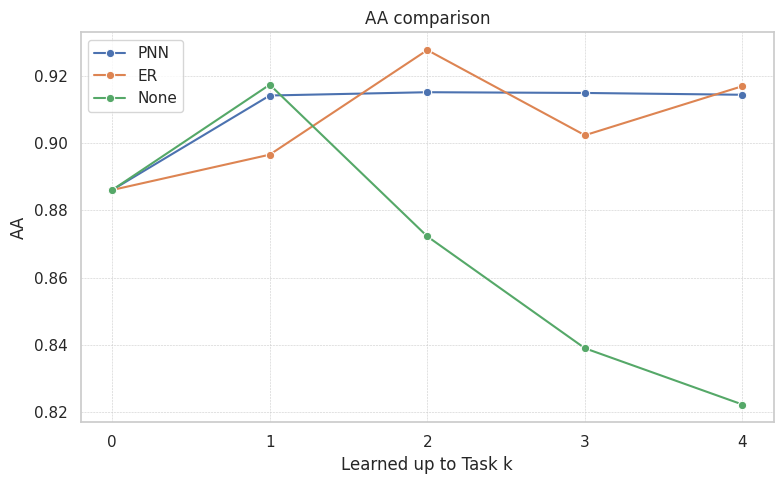

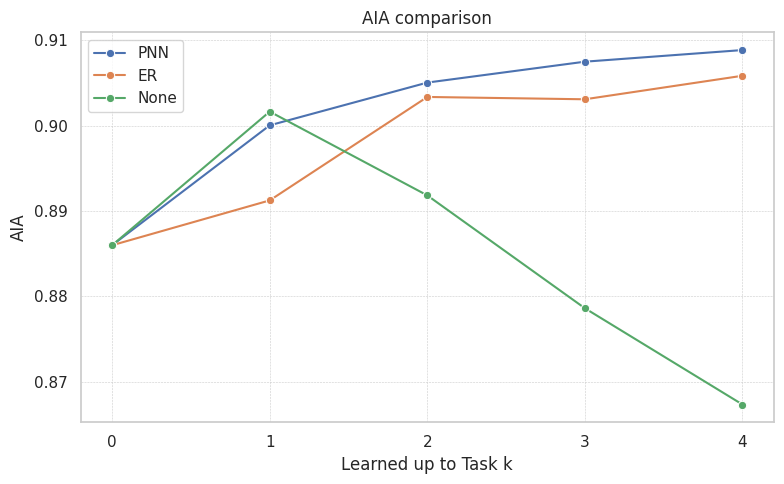

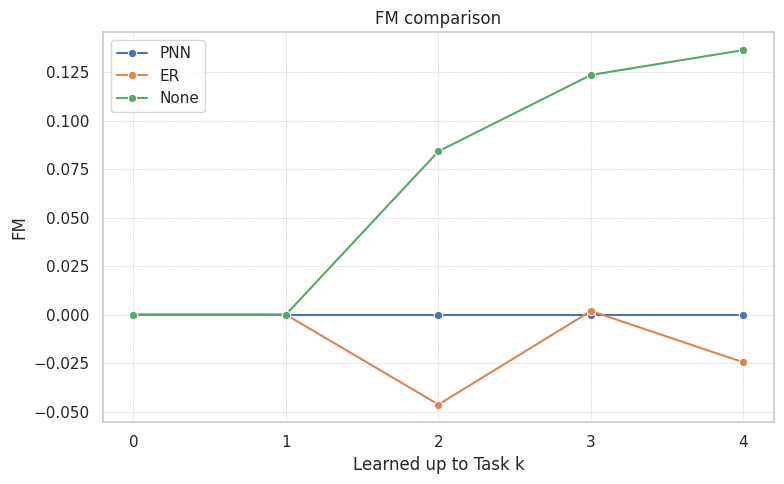

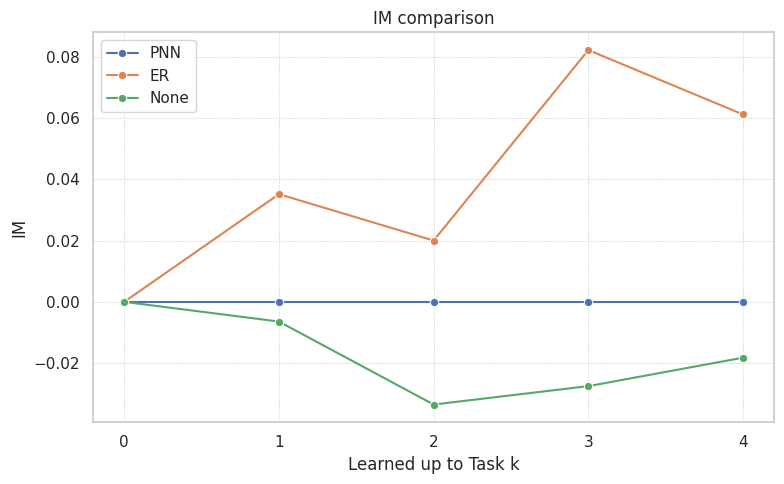

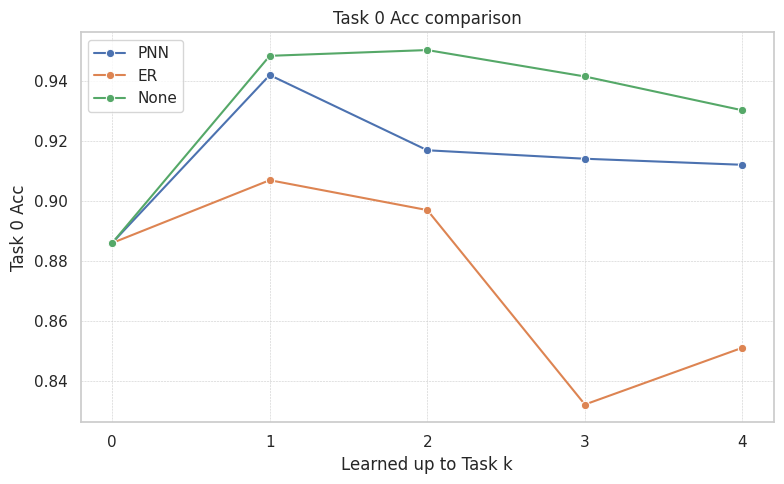

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- ファイルパス（手法ごとにCSVを用意） ---
csv_files = {
    "PNN": "/work/csv/uci-har/cil-pnn.csv",
    "EWC": "/work/csv/uci-har/cil-ewc/lambda100000.csv",
    "ER": "/work/csv/uci-har/cil-er/mem3000_bs64.csv",
    "None": "/work/csv/uci-har/cil/ltc_ncps.csv",
}

joint_csv = "/work/csv/uci-har/cil-joint/ltc_ncps.csv"  # Joint baseline

# --- 指標計算関数 ---
def compute_metrics(acc_matrix: np.ndarray, joint_acc: np.ndarray | None = None):
    num_tasks = 5
    AA_list, AIA_list = [], []
    for k in range(num_tasks):
        current_accs = acc_matrix[k][: k + 1] if k < len(acc_matrix) else []
        AA_k = float(np.mean(current_accs)) if len(current_accs) > 0 else 0.0
        AA_list.append(AA_k)
        AIA_k = float(np.mean(AA_list)) if len(AA_list) > 0 else 0.0
        AIA_list.append(AIA_k)

    # FM (forgetting) — make length == num_tasks, FM[0]=0.0
    fm_list = []
    if num_tasks == 0:
        fm_list = []
    else:
        fm_list = [0.0]
        for k in range(1, num_tasks):
            forgetting_sum = 0.0
            for j in range(k):
                # collect past accuracies on task j for times l in [j, k-1]
                past_accs = []
                for l in range(j, k):
                    if l < len(acc_matrix) and j < len(acc_matrix[l]):
                        past_accs.append(acc_matrix[l][j])
                max_past_acc = max(past_accs) if past_accs else 0.0
                current_acc = acc_matrix[k][j] if (k < len(acc_matrix) and j < len(acc_matrix[k])) else 0.0
                forgetting_sum += (max_past_acc - current_acc)
            fm_list.append(forgetting_sum / k if k > 0 else 0.0)

    # IM (idealized marginal) : joint_acc[k] - acc_matrix[k][k]
    im_list = []
    for k in range(num_tasks):
        if joint_acc is not None and k < len(joint_acc):
            cl_acc_k = acc_matrix[k][k] if (k < len(acc_matrix) and k < len(acc_matrix[k])) else np.nan
            im_list.append(joint_acc[k] - cl_acc_k)
        else:
            im_list.append(np.nan)

    results=[]

    for k in range(num_tasks):
        results.append({
            'Task': k,
            'AA': AA_list[k],
            'AIA': AIA_list[k],
            'FM': fm_list[k],
            'IM': im_list[k],
            'Task 0 Acc': acc_matrix[k][k]
        })

    metrics_df = pd.DataFrame(results)
    return metrics_df

# --- Joint baselineの読み込み ---
if os.path.exists(joint_csv):
    df_joint = pd.read_csv(joint_csv)
    joint_acc = df_joint["テスト精度 (Test Acc)"].values
else:
    joint_acc = None

# --- 全手法のmetrics計算 ---
all_metrics = {}

for method, path in csv_files.items():
    if not os.path.exists(path):
        print(f"{method} CSV not found: {path}")
        continue
    
    df = pd.read_csv(path)
    num_tasks = 5
    
def build_acc_matrix_pnn(df, num_tasks):
    df_pnn = pd.read_csv(csv_files["PNN"])
    num_tasks = int(df_pnn["task"].nunique())
    acc_matrix = np.zeros((num_tasks, num_tasks), dtype=float)
    original_acc = []

    for k in range(num_tasks):
        val = df_pnn.loc[df_pnn["task"] == k, "テスト精度 (Test Acc)"].values[0]
        if k == 0:
            row = [val]
        else:
            # 前タスクの精度をコピーして最後に今回の精度を追加
            row = original_acc[-1] + [val]
        original_acc.append(row)
    return original_acc

def build_acc_matrix_ewc(df, num_tasks):
    df = pd.read_csv(csv_files["EWC"])
    accuracies = df['テスト精度 (Test Acc)'].tolist()

    # acc_matrix を構築
    acc_matrix = []
    idx = 0
    for k in range(num_tasks):
        row = accuracies[idx: idx + k + 1]
        acc_matrix.append(row)
        idx += k + 1
    return acc_matrix

def build_acc_matrix_er(df, num_tasks):
    df = pd.read_csv(csv_files["ER"])
    accuracies = df['テスト精度 (Test Acc)'].tolist()

    # --- acc_matrix構築 ---
    acc_matrix = []
    idx = 0
    for k in range(num_tasks):
        row = accuracies[idx: idx + k + 1]
        acc_matrix.append(row)
        idx += k + 1

    return acc_matrix

def build_acc_matrix_none(df, num_tasks):
    df = pd.read_csv(csv_files["None"])
    accuracies = df['テスト精度 (Test Acc)'].tolist()

    # --- acc_matrix構築 ---
    acc_matrix = []
    idx = 0
    for k in range(num_tasks):
        row = accuracies[idx: idx + k + 1]
        acc_matrix.append(row)
        idx += k + 1

    return acc_matrix

for method, path in csv_files.items():
    if not os.path.exists(path):
        print(f"{method} CSV not found: {path}")
        continue
    df = pd.read_csv(path)
    num_tasks = 5
    if df_joint is not None:
        joint_acc = df_joint["テスト精度 (Test Acc)"].values[:num_tasks]
    else:
        joint_acc = None
    acc_matrix = None
    if method == "PNN":
        acc_matrix = build_acc_matrix_pnn(df, num_tasks)
    elif method == "EWC":
        acc_matrix = build_acc_matrix_ewc(df, num_tasks)
    elif method == "ER":    
        acc_matrix = build_acc_matrix_er(df, num_tasks)
    elif method == "None":
        acc_matrix = build_acc_matrix_none(df, num_tasks)
    print(f"{method} accuracy matrix:\n{acc_matrix}")
    df_metrics = compute_metrics(acc_matrix, joint_acc)
    all_metrics[method] = df_metrics            


# --- 可視化 ---
sns.set(style="whitegrid")
metrics_to_plot = ["AA", "AIA", "FM", "IM", "Task 0 Acc"]

for metric in metrics_to_plot:
    plt.figure(figsize=(8,5))
    for method, df_metric in all_metrics.items():
        sns.lineplot(data=df_metric, x="Task", y=metric, marker="o", label=method)
    plt.title(f"{metric} comparison")
    plt.xlabel("Learned up to Task k")
    plt.xticks(range(num_tasks))
    plt.grid(True, linestyle="--", linewidth=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [31]:
import os
import pandas as pd
seeds = [1, 2, 3, 4, 5]
num_tasks = 3
def make_metrics_none(base_path):    
    accs_per_seed = []
    overall_accs_per_seed = []

    # --- 各シードの2回目 inferenceだけを抽出 ---
    for seed in seeds:
        file_path = os.path.join(base_path, f"seed{seed}.csv")
        if not os.path.exists(file_path):
            print(f"警告: ファイルが存在しません: {file_path}")
            continue
        df = pd.read_csv(file_path)


        # 各タスクの 2 回目の inference
        inf2_index = df.groupby('task').nth(1).index if not df.empty else []
        df_filtered = df.drop(index=inf2_index)

        # --- 逆三角形 acc_matrix 用にテスト精度を抽出 ---
        acc_list = df_filtered['テスト精度 (Test Acc)'].tolist()
        accs_per_seed.append(acc_list)

    # --- overall_acc 用に 2回目 inference のみ抽出 ---
        if len(inf2_index) > 0:
            overall_accs_per_seed.append(df.loc[inf2_index, 'テスト精度 (Test Acc)'].tolist())
        else:
            overall_accs_per_seed.append([])

    # --- シード平均 ---
    max_len = max(len(lst) for lst in accs_per_seed)
    accs_avg = []
    for i in range(max_len):
        vals = [lst[i] for lst in accs_per_seed if i < len(lst)]
        accs_avg.append(sum(vals)/len(vals))
    
    # --- 逆三角形の acc_matrix 作成 ---
    acc_matrix = []
    current_pos = 0
    for k in range(num_tasks):
        row_len = k+1  # 下三角分だけ
        row=accs_avg[current_pos: current_pos + row_len]
        acc_matrix.append(row[::-1]) 
        current_pos += row_len
    
    # --- overall_acc をシード平均で計算 ---
    overall_acc_avg = []
    # overall_accs_per_seed はリストのリスト [[seed1のinf2],[seed2のinf2],...]
    # transposeしてタスクごとに平均
    if overall_accs_per_seed and any(overall_accs_per_seed):
        max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
        for i in range(max_len_overall):
            vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
            overall_acc_avg.append(sum(vals)/len(vals))
    else:
        overall_acc_avg = [np.nan]*num_tasks

    return acc_matrix, overall_acc_avg

make_metrics_fine("/work/csv/uci-har/cil_each/ncp")

([[0.9267499923706055],
  [0.199399995803833, 0.9667499899864197],
  [0.0, 0.0, 0.7965999960899353]],
 [0.7394999980926513, 0.472222226858139, 0.3662857174873352])

In [32]:
def make_metrics_ewc(base_dir):
    acc_matrices_per_seed = []
    overall_accs_per_seed = []
    for seed in seeds:
        file_path = os.path.join(base_dir, f"seed{seed}.csv")

        df = pd.read_csv(file_path)

        # --- 2回目 inference の抽出 ---
        inf2_df = df.groupby('task').nth(1)  # 各タスク2行目
        overall_accs = inf2_df['テスト精度 (Test Acc)'].tolist()
        overall_accs_per_seed.append(overall_accs)
        df_filtered = df.drop(index=inf2_df.index)

        # --- acc_matrix 構築 ---
        acc_list = df_filtered['テスト精度 (Test Acc)'].tolist()
        acc_matrix = []
        idx = 0
        for k in range(num_tasks):
            row = acc_list[idx: idx + k + 1]
            acc_matrix.append(row)
            idx += k + 1
        acc_matrices_per_seed.append(acc_matrix)


    # --- seed 平均 ---
    # acc_matrix 平均を作成
    max_len = max(len(m) for m in acc_matrices_per_seed)
    acc_matrix_avg = []
    for k in range(num_tasks):
        rows = []
        for m in acc_matrices_per_seed:
            if k < len(m):
                rows.append(m[k])
        if rows:
            row_len = max(len(r) for r in rows)
            row_avg = []
            for j in range(row_len):
                vals = [r[j] for r in rows if j < len(r)]
                row_avg.append(sum(vals)/len(vals) if vals else np.nan)
            acc_matrix_avg.append(row_avg)

    # --- overall_acc 平均 ---
    max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
    overall_acc_avg = []
    for i in range(max_len_overall):    
        vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
        overall_acc_avg.append(sum(vals)/len(vals) if vals else np.nan)
    
    return acc_matrix_avg, overall_acc_avg
make_metrics_ewc("/work/csv/uci-har/cil_each/ewc/lambda50000")

([[0.9267499923706055],
  [0.0, 0.971749997138977],
  [0.01199999973177908, 0.11200000122189517, 0.9807999968528748]],
 [0.9267499923706055, 0.4752222239971161, 0.3854285717010498])

In [33]:
def make_metrics_er(base_dir,mem,bs):
    acc_matrices_per_seed = []
    overall_accs_per_seed = []
    for seed in seeds:
        file_path = os.path.join(base_dir, f"seed{seed}",  f"mem{mem}", f"bs{bs}.csv")

        df = pd.read_csv(file_path)

        # --- 2回目 inference の抽出 ---
        inf2_df = df.groupby('task').nth(1)  # 各タスク2行目
        overall_accs = inf2_df['テスト精度 (Test Acc)'].tolist()
        overall_accs_per_seed.append(overall_accs)
        df_filtered = df.drop(index=inf2_df.index)

        # --- acc_matrix 構築 ---
        acc_list = df_filtered['テスト精度 (Test Acc)'].tolist()
        acc_matrix = []
        idx = 0
        for k in range(num_tasks):
            row = acc_list[idx: idx + k + 1]
            acc_matrix.append(row)
            idx += k + 1
        acc_matrices_per_seed.append(acc_matrix)


    # --- seed 平均 ---
    # acc_matrix 平均を作成
    max_len = max(len(m) for m in acc_matrices_per_seed)
    acc_matrix_avg = []
    for k in range(num_tasks):
        rows = []
        for m in acc_matrices_per_seed:
            if k < len(m):
                rows.append(m[k])
        if rows:
            row_len = max(len(r) for r in rows)
            row_avg = []
            for j in range(row_len):
                vals = [r[j] for r in rows if j < len(r)]
                row_avg.append(sum(vals)/len(vals) if vals else np.nan)
            acc_matrix_avg.append(row_avg)

    # --- overall_acc 平均 ---
    max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
    overall_acc_avg = []
    for i in range(max_len_overall):    
        vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
        overall_acc_avg.append(sum(vals)/len(vals) if vals else np.nan)
    
    return acc_matrix_avg, overall_acc_avg
make_metrics_er("/work/csv/uci-har/cil_each/er", 5000, 10)

([[0.9267499923706055],
  [0.8952499985694885, 0.9177500009536743],
  [0.93125, 0.9174999952316284, 0.9866000056266785]],
 [0.9267499923706055, 0.7922222137451171, 0.6891428589820862])

In [34]:
seeds = [1, 2, 3, 4, 5]
num_tasks = 3

def make_metrics_pnn(base_dir):
    acc_metrics_per_seed = []      # seedごとの結果をためる
    overall_accs_per_seed = []     # overall acc を seed ごとに保存

    for seed in seeds:
        csv_path = os.path.join(base_dir, f"seed{seed}.csv")
        if not os.path.exists(csv_path):
            print(f"警告: CSVが存在しません: {csv_path}")
            continue

        df = pd.read_csv(csv_path)

        # --- 2回目 inference を overall として抽出 ---
        overall_accs = df[df["phase_type"]=="inference"]["テスト精度 (Test Acc)"].tolist()
        overall_accs_per_seed.append(overall_accs)

        # --- 1回目 inference（acc_list） ---
        acc_list = df[df["phase_type"]=="training"]["テスト精度 (Test Acc)"].tolist()
        print(f"Seed {seed} Acc List: {acc_list}")
        if len(acc_list) != num_tasks:
            print(f"警告: Task数と一致しません Seed {seed}")

        # --- 指標計算 ---
        df_seed = pd.DataFrame({
            "Task": list(range(1, num_tasks+1)),
            "Acc": acc_list,
            "Overall Acc": overall_accs[:num_tasks]  # safety
        })
        df_seed["Seed"] = seed
        acc_metrics_per_seed.append(df_seed)

    # --- overall_acc 平均 ---
    max_len_overall = max(len(lst) for lst in overall_accs_per_seed)
    overall_acc_avg = []
    for i in range(max_len_overall):    
        vals = [lst[i] for lst in overall_accs_per_seed if i < len(lst)]
        overall_acc_avg.append(sum(vals)/len(vals) if vals else np.nan)

    # --- 逆三角形 acc_matrix 作成（対角のみ保持） ---
    acc_matrix = []
    for k in range(num_tasks):
        row = [0] * num_tasks
        vals = [df_seed.iloc[k]["Acc"] for df_seed in acc_metrics_per_seed if k < len(df_seed)]
        row[k] = sum(vals)/len(vals) if vals else np.nan
        acc_matrix.append(row)

    return acc_matrix, overall_acc_avg

make_metrics_pnn("/work/csv/uci-har/cil_each/pnn")

Seed 1 Acc List: [0.9362499713897704, 0.9662500023841858, 1.0]
Seed 2 Acc List: [0.8987500071525574, 0.96875, 0.9990000128746032]
Seed 3 Acc List: [0.928749978542328, 0.96875, 0.9739999771118164]
Seed 4 Acc List: [0.8987500071525574, 0.9674999713897704, 0.9869999885559082]
Seed 5 Acc List: [0.9712499976158142, 0.9674999713897704, 1.0]


([[0.9267499923706055, 0, 0],
  [0, 0.9677499890327453, 0],
  [0, 0, 0.9919999957084655]],
 [0.9267499923706055, 0.4706666707992554, 0.35742856860160827])

In [35]:
def make_joint_metrics(base_dir):
    joint_accs_per_seed = []
    for seed in seeds:
        joint_file_path = os.path.join(base_dir, f"seed{seed}.csv")
        df_joint = pd.read_csv(joint_file_path)
         # --- joint acc ---
        joint_accs = df_joint['テスト精度 (Test Acc)'].head(num_tasks).tolist()
        joint_accs_per_seed.append(joint_accs)

     # joint 平均
    joint_accs_avg = []
    for t in range(num_tasks):
        vals = [lst[t] for lst in joint_accs_per_seed if t < len(lst)]
        joint_accs_avg.append(sum(vals)/len(vals) if vals else np.nan)

    return joint_accs_avg
make_joint_metrics("/work/csv/uci-har/cil_each/ncp/joint")

[0.9267499923706055, 0.9502222299575805, 0.9070000171661377]

Seed 1 Acc List: [0.9362499713897704, 0.9662500023841858, 1.0]
Seed 2 Acc List: [0.8987500071525574, 0.96875, 0.9990000128746032]
Seed 3 Acc List: [0.928749978542328, 0.96875, 0.9739999771118164]
Seed 4 Acc List: [0.8987500071525574, 0.9674999713897704, 0.9869999885559082]
Seed 5 Acc List: [0.9712499976158142, 0.9674999713897704, 1.0]


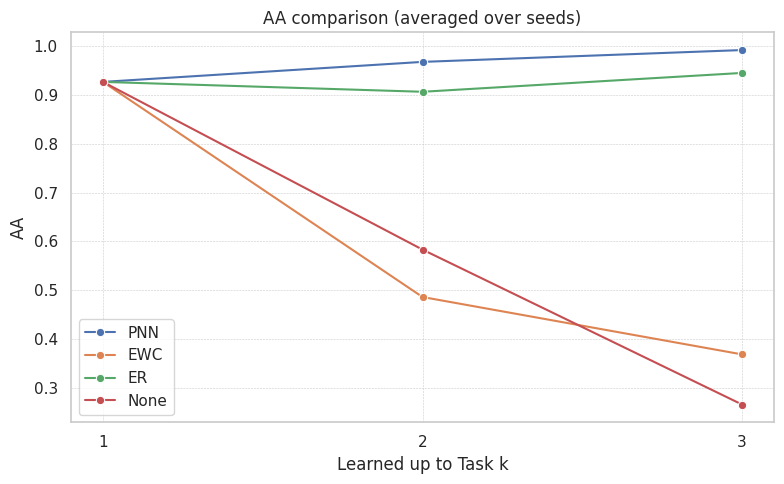

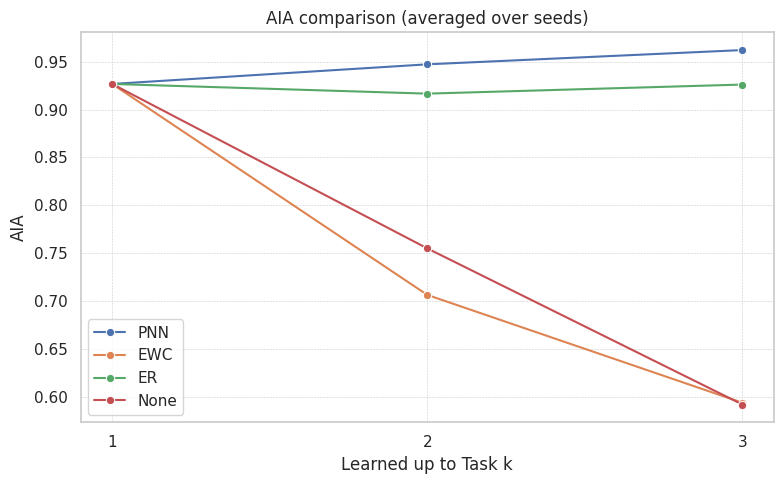

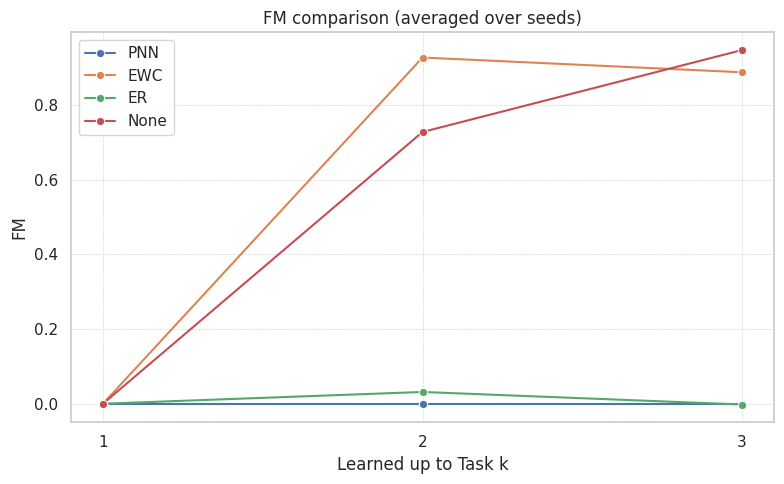

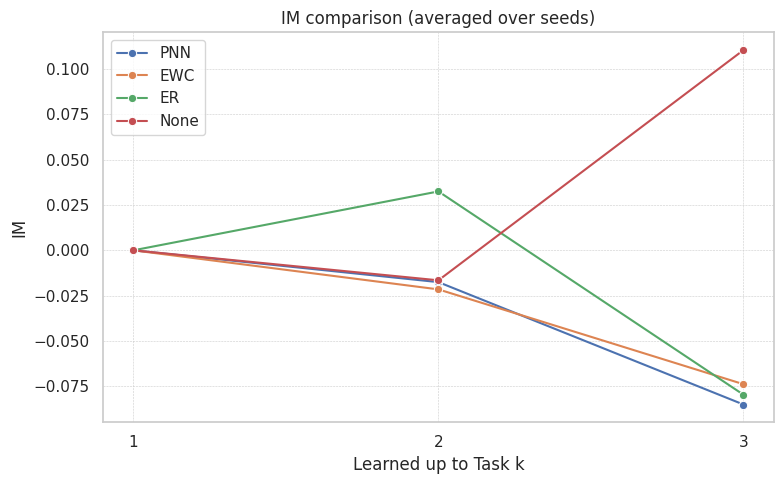

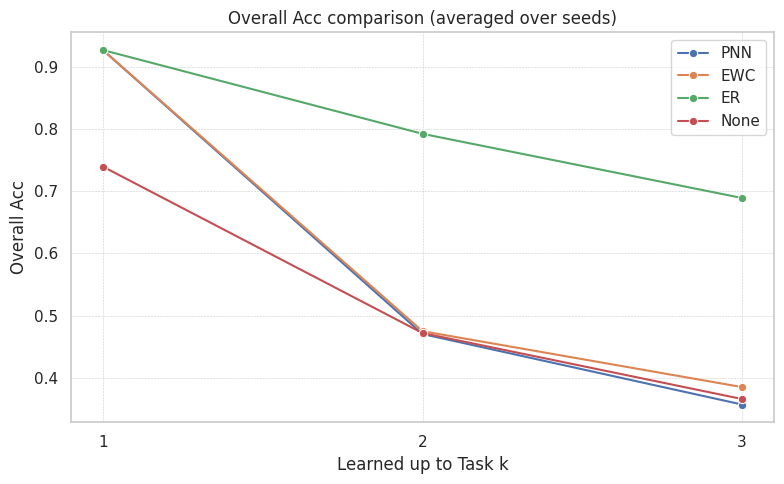

In [45]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- CSVディレクトリパス ---
csv_dirs = {
    "PNN": "/work/csv/uci-har/cil_each/pnn",
    "EWC": "/work/csv/uci-har/cil_each/ewc/lambda50000",
    "ER": "/work/csv/uci-har/cil_each/er",
    "None": "/work/csv/uci-har/cil_each/ncp",
}
joint_csv = "/work/csv/uci-har/cil_each/ncp/joint"

# --- 指標計算関数 ---
def compute_metrics(acc_matrix, joint_acc=None, overall_acc_avg=None):
    num_tasks = len(acc_matrix)
    AA_list, AIA_list, fm_list, im_list = [], [], [], []

    for k in range(num_tasks):
        current_accs = acc_matrix[k][:k+1]
        AA_list.append(float(np.mean(current_accs)) if current_accs else 0.0)
        AIA_list.append(float(np.mean(AA_list)))

    fm_list.append(0.0)
    for k in range(1, num_tasks):
        forgetting_sum = 0.0
        for j in range(k):
            past_accs = [acc_matrix[l][j] for l in range(j, k) if l < len(acc_matrix) and j < len(acc_matrix[l])]
            max_past_acc = max(past_accs) if past_accs else 0.0
            current_acc = acc_matrix[k][j] if k < len(acc_matrix) and j < len(acc_matrix[k]) else 0.0
            forgetting_sum += (max_past_acc - current_acc)
        fm_list.append(forgetting_sum / k)

    for k in range(num_tasks):
        if joint_acc is not None and k < len(joint_acc):
            cl_acc_k = acc_matrix[k][k] if k < len(acc_matrix[k]) else np.nan
            im_list.append(joint_acc[k] - cl_acc_k)
        else:
            im_list.append(np.nan)

    results = []
    for k in range(num_tasks):
        results.append({
            'Task': k+1,
            'AA': AA_list[k],
            'AIA': AIA_list[k],
            'FM': fm_list[k],
            'IM': im_list[k],
            'Overall Acc': overall_acc_avg[k]
        })
    return pd.DataFrame(results)


def compute_metrics_pnn(acc_matrix, joint_acc=None, overall_acc=None):
    num_tasks = len(acc_matrix)
    AA_list, AIA_list, fm_list, im_list = [], [], [], []

    for k in range(num_tasks):
        current_accs = acc_matrix[k][k]
        AA_list.append(float(np.mean(current_accs)) if current_accs else 0.0)
        AIA_list.append(float(np.mean(AA_list)))

    fm_list=[0.0]*num_tasks

    for k in range(num_tasks):
        if joint_acc is not None and k < len(joint_acc):
            cl_acc_k = acc_matrix[k][k] if k < len(acc_matrix[k]) else np.nan
            im_list.append(joint_acc[k] - cl_acc_k)
        else:
            im_list.append(np.nan)

    results = []
    for k in range(num_tasks):
        results.append({
            'Task': k+1,
            'AA': AA_list[k],
            'AIA': AIA_list[k],
            'FM': fm_list[k],
            'IM': im_list[k],
            'Overall Acc': overall_acc_avg[k]
        })
    return pd.DataFrame(results)

seeds = [1, 2, 3, 4, 5]
num_tasks = 3
# --- ディレクトリ内の全seedを読み込み & 平均化 ---
for method, dir_path in csv_dirs.items():
    if method == "PNN":
        make_metrics_func = make_metrics_pnn
    elif method == "EWC":
        make_metrics_func = make_metrics_ewc
    elif method == "ER":
        make_metrics_func = lambda p: make_metrics_er(p, 5000, 10)
    elif method == "None":
        make_metrics_func = make_metrics_none
    acc_matrix, overall_acc_avg = make_metrics_func(dir_path)
    joint_acc_avg = make_joint_metrics(joint_csv) if os.path.exists(joint_csv) else None
    if method == "PNN":
        df_metrics = compute_metrics_pnn(acc_matrix, joint_acc_avg, overall_acc_avg)
    else:
        df_metrics = compute_metrics(acc_matrix, joint_acc_avg, overall_acc_avg)
    all_metrics[method] = df_metrics

# --- 可視化 ---
sns.set(style="whitegrid")
metrics_to_plot = ["AA", "AIA", "FM", "IM", "Overall Acc"]

for metric in metrics_to_plot:
    plt.figure(figsize=(8,5))
    for method, df_metric in all_metrics.items():
        sns.lineplot(data=df_metric, x="Task", y=metric, marker="o", label=method)
    plt.title(f"{metric} comparison (averaged over seeds)")
    plt.xlabel("Learned up to Task k")
    plt.xticks(range(1, num_tasks+1))
    plt.grid(True, linestyle="--", linewidth=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
